In [1]:
from pycbc.detector import Detector
from pycbc.waveform import get_td_waveform, get_fd_waveform

# Time, orientation and location of the source in the sky
ra = 1.7
dec = 1.7
pol = 0.2
inc = 0
time = 1000

# We can calcualate the antenna pattern for Hanford at
# the specific sky location
d = Detector("H1")

# We get back the fp and fc antenna pattern weights.
fp, fc = d.antenna_pattern(ra, dec, pol, time)
print("fp={}, fc={}".format(fp, fc))

# These factors allow us to project a signal into what the detector would
# observe

## Generate a waveform
hp, hc = get_td_waveform(approximant="IMRPhenomPv2", mass1=20, mass2=10,
                         f_lower=30, delta_t=1.0/8192, inclination=inc,
                         spin1z = 0.2, spin2z = 0.4,
                         distance=400)

## Apply the factors to get the detector frame strain
ht = fp * hp + fc * hc


# The projection process can also take into account the rotation of the
# earth using the project wave function.
hp.start_time = hc.start_time = time
ht = d.project_wave(hp, hc, ra, dec, pol)

fp=0.4654056957426748, fc=-0.6002321751715405


In [2]:
import pycbc.psd
import pycbc.noise

data_length = 3
sample_rate = 8192
flow = 30.0
delta_f = 1.0 / 128
flen = int(8192 / (delta_f) ) + 1   #1024*128 + 1
#psd_inc = pycbc.psd.aLIGOZeroDetHighPowerGWINC(flen, delta_f, flow)
psd = pycbc.psd.aLIGOZeroDetHighPower(flen, delta_f, flow)

delta_t = 1.0 / sample_rate


ts = pycbc.noise.noise_from_psd(8192, delta_t, psd)


print(len(ts))

8192


In [3]:
import numpy as np
freq_txt = np.array(psd.sample_frequencies)
freq_txt = freq_txt[:int(len(freq_txt)/3)]
psd_txt = np.array(psd)
psd_txt = psd_txt[:int(len(psd_txt)/3)]
X = [freq_txt,psd_txt]
print(np.array(X).shape)
np.savetxt("PSD.txt",X)

(2, 349525)


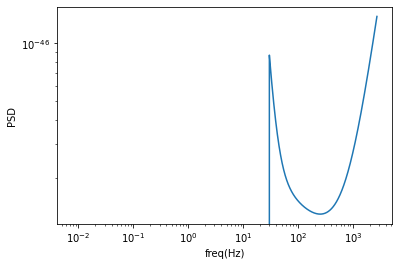

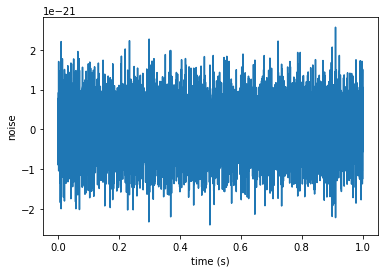

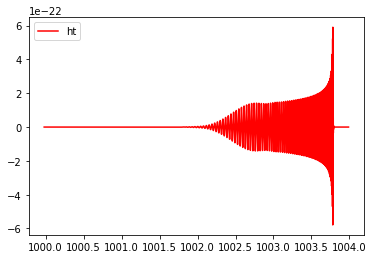

In [4]:
import matplotlib.pyplot as plt

# plt.plot(psd.sample_frequencies, psd)
plt.plot(freq_txt,psd_txt)
plt.xlabel("freq(Hz)")
plt.ylabel("PSD")
plt.xscale("log")
plt.yscale("log")
# plt.xlim((30,6000))
plt.show()

plt.plot(ts.sample_times, ts)
plt.xlabel("time (s)")
plt.ylabel("noise")
plt.show()

#ht_sample_times =np.array(ht.sample_times)
#plt.title('Gaussian noise + Simulated noise signal in Advanced LIGO')
plt.plot(ht.sample_times[:], ht[:] , label="ht",color = 'red')
#plt.plot( time, sig_noi , label="signal+noise",color = 'red')
#plt.savefig("noise.png")
#plt.plot( ts_inc.sample_times, ts_inc ,label = "GWINC", color = 'red', alpha=0.6)
#plt.xlim((-0.8,0.2))
plt.legend()
plt.show()

In [5]:
print(ht.shape)
ht = ht[ht.shape[0]-8192:]
print(ht.shape)
ht.start_time = ts.start_time
#ts = ts[0,8192]
#ht_arr = ht.numpy()
ts_arr = ts.numpy()
print(ts.shape)
#waveform_start = np.random.randint(len(ts)-len(ht))
# data = ts_arr[waveform_start:waveform_start+len(ht)] + ht_arr
data = ht+ts
time = ht.sample_times
print(time.shape)

(32834,)
(8192,)
(8192,)
(8192,)


In [6]:
X_data = [time,data]
np.save("data.npy",X_data)

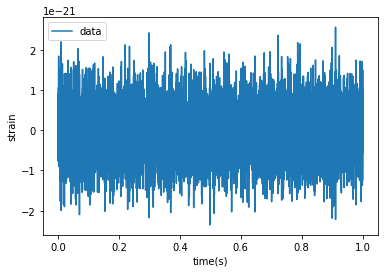

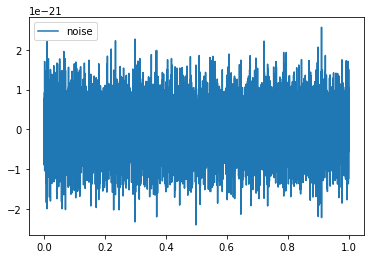

In [7]:
plt.plot(time,data ,label="data")
plt.xlabel("time(s)")
plt.ylabel("strain")

plt.legend()
plt.show()
plt.plot(time, ts, label = "noise")
plt.legend()
plt.show()

(8192,)


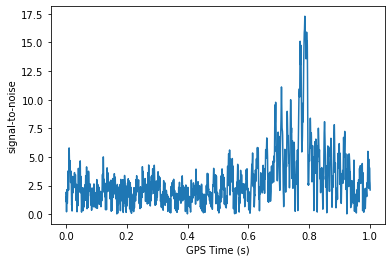

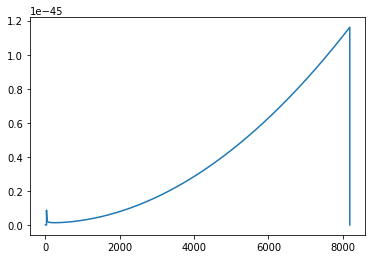

In [8]:
#Generate SNR and estimate psd from data
from pycbc.frame import read_frame
from pycbc.filter import highpass_fir, matched_filter
from pycbc.waveform import get_fd_waveform
from pycbc.psd import welch, interpolate
try:
    from urllib.request import urlretrieve
except ImportError:  # python < 3
    from urllib import urlretrieve

# Read data and remove low frequency content
# fname = 'H-H1_LOSC_4_V2-1126259446-32.gwf'
# url = "https://www.gw-openscience.org/GW150914data/" + fname
# urlretrieve(url, filename=fname)
# h1 = read_frame('H-H1_LOSC_4_V2-1126259446-32.gwf', 'H1:LOSC-STRAIN')
# h1 = highpass_fir(h1, 15, 8)

# Calculate the noise spectrum
psd_data = interpolate(welch(data), 1.0 / (len(time)/sample_rate))

# Generate a template to filter with
hp, hc = get_fd_waveform(approximant="IMRPhenomD", mass1=20, mass2=10,
                         f_lower=30, delta_f=1.0/(len(time)/sample_rate))
hp.resize(len(data) // 2 + 1)

# Calculate the complex (two-phase SNR)
snr = matched_filter(hp, data, psd=psd_data, low_frequency_cutoff=30.0)

# Remove regions corrupted by filter wraparound
#snr = snr[len(snr) // 4: len(snr) * 3 // 4]
print(snr.shape)
plt.plot(snr.sample_times, abs(snr))
plt.ylabel('signal-to-noise')
plt.xlabel('GPS Time (s)')
plt.show()

plt.plot(psd.sample_frequencies, psd)
#plt.plot(psd_data.sample_frequencies, psd_data)
plt.show()

(4097,)
(8192,)
4097


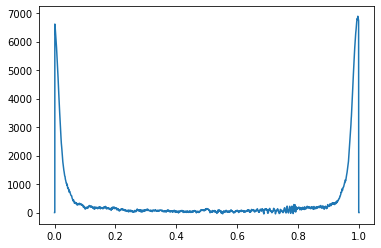

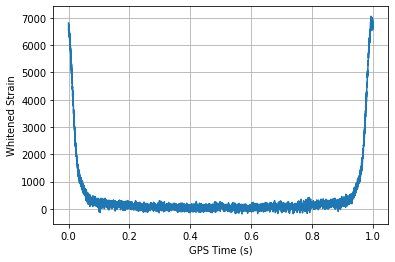

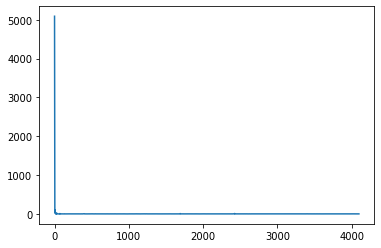

In [9]:
from pycbc.frame import read_frame
from pycbc.filter import highpass_fir, lowpass_fir
from pycbc.waveform import get_fd_waveform
from pycbc.psd import welch, interpolate
from pycbc.catalog import Merger
import pylab

#for ifo in ['H1', 'L1']:
# Read data and remove low frequency content
#h1 = Merger("GW150914").strain(ifo)
#h1 = highpass_fir(h1, 15, 8)

# Calculate the noise spectrum
psd = interpolate(welch(data), 1.0 / (len(time)/sample_rate))
print(psd.shape)
# whiten
print(data.shape)
datafreq = data.to_frequencyseries()
print(datafreq.shape[0])
white_strain = (datafreq/psd**0.5).to_timeseries()
psd_new = interpolate(welch(white_strain), 1.0 / (len(time)/sample_rate))
#white_strain = (data.to_frequencyseries() / psd ** 0.5).to_timeseries()

# remove some of the high and low
smooth = highpass_fir(white_strain, 10, 8)
smooth = lowpass_fir(white_strain, 200, 8)

# time shift and flip L1
#     if ifo == 'L1':
#         smooth *= -1
#         smooth.roll(int(.007 / smooth.delta_t))

plt.plot(smooth.sample_times, smooth)
#plt.xlim((0.6,0.9))
#plt.ylim((-250,250))
plt.show()

plt.plot(white_strain.sample_times, white_strain)
plt.ylabel('Whitened Strain')
plt.grid()
plt.xlabel('GPS Time (s)')
plt.show()

plt.plot(psd_new.sample_frequencies,psd_new)